In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import json
import scipy.stats as stats
import statsmodels.stats.multitest as smm
from statsmodels.stats.multitest import fdrcorrection

feature_names = json.loads(open('utils/lut_dict.txt').read())

In [36]:
# HISTOGRAM
#############################################################

# create dataframes
important_features = pd.read_csv("out/important_features.csv")
ml_dataframe = pd.read_csv("stats/ml_dataframe.csv")

# rename columns 
important_features = important_features.rename(columns={'feature': 'importance'})
important_features = important_features.rename(columns={'Unnamed: 0': 'feature'})

# save names of features where importance >=5 to a list called top_features
top_features = important_features[important_features['importance'] >= 5]
top_features = top_features['feature'].tolist()

# top features' importance list
top_features_importance = important_features[important_features['importance'] >= 5]
top_features_importance = top_features_importance['importance'].tolist()

# reading LUT
region_names = np.array(list([feature_names[feature] for feature in important_features['feature']]))

# add label column
important_features['feature type'] = np.where(important_features['feature'].str.contains('thickness'), "thickness", 
                                       np.where(important_features['feature'].str.contains('area'), "area", "volume"))
important_features['feature'] = region_names


In [37]:
# generate histogram
with plt.xkcd():
    ax1 = sns.catplot(data=important_features, kind="bar", x="importance", y="feature", height=15, hue="feature type", dodge=False, palette=['#6EE3A8', '#6E8CE3', '#E36EB1'])
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10])    
    plt.savefig('out/important_features.png', dpi=300)
    plt.clf()

<Figure size 1198.15x1080 with 0 Axes>

In [38]:
# FEATURE WEIGHTS
#############################################################

# make a graph to visualize the feature weights data in outs folder ([fold]_feature_weights.csv)
#load df from all folds and merge into one dataframe

#create new dataframe for each fold file

dataframes = []  # List to store the dataframes

for i in range(0,10):
    filename=('out/{}_feature_weights.csv'.format(i))
     # Generate the filename
    df = pd.read_csv(filename)  # Read the CSV file into a dataframe
    dataframes.append(df)

# rename first column of each dataframe to fold #
for i in range(0,10):
    dataframes[i] = dataframes[i].rename(columns={'Unnamed: 0': 'fold #'})
    dataframes[i]['fold #'] = i

# merge all 10 dataframes within dataframes list into a single dataframe
all_weights = pd.concat(dataframes)

all_weights.head()


,fold #,lh_PuI,rh_S_collat_transv_ant_thickness,lh_VPL,lh_S_circular_insula_inf_thickness,rh_G_insular_short_thickness,rh_S_intrapariet&P_trans_area,rh_S_cingul-Marginalis_thickness,rh_S_front_sup_thickness,rh_S_front_middle_area,...,lh_Pole_occipital_area,rh_G_postcentral_area,lh_G_front_inf-Orbital_area,rh_S_orbital_lateral_thickness,lh_Pole_temporal_thickness,lh_S_oc-temp_med&Lingual_area,lh_hippocampal-fissure,lh_S_precentral-inf-part_area,lh_Paralaminar-nucleus,rh_MGN
0,0,0.405234,-0.200833,-0.532841,-0.182240,0.156519,0.163558,0.363084,0.181643,0.310654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,0.626082,NaN,-0.816364,-0.282732,NaN,0.295778,0.350158,NaN,0.284697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2,0.346750,-0.166399,-0.206517,-0.215367,0.103590,NaN,0.368143,0.171611,0.171736,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3,0.683926,NaN,-0.433924,-0.176295,NaN,NaN,NaN,0.328572,0.161186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.211662,0.245917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# melt
all_weights = pd.melt(all_weights, id_vars=['fold #'], var_name='feature', value_name='weight')
print(all_weights)

     fold # feature    weight
0         0  lh_PuI  0.405234
1         1  lh_PuI  0.626082
2         2  lh_PuI  0.346750
3         3  lh_PuI  0.683926
4         4  lh_PuI       NaN
..      ...     ...       ...
545       5  rh_MGN       NaN
546       6  rh_MGN       NaN
547       7  rh_MGN       NaN
548       8  rh_MGN       NaN
549       9  rh_MGN  0.450955

[550 rows x 3 columns]


In [40]:
# keep only top weights / replace column headers with feature_names from lut_dict.txt
top_weights = all_weights[all_weights['feature'].isin(top_features)]
region_names = np.array(list([feature_names[feature] for feature in top_weights['feature']]))
top_weights['feature'] = region_names

# abs value
top_weights['weight'] = top_weights['weight'].abs()

/tmp/ipykernel_30551/1125540025.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_weights['feature'] = region_names
/tmp/ipykernel_30551/1125540025.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_weights['weight'] = top_weights['weight'].abs()


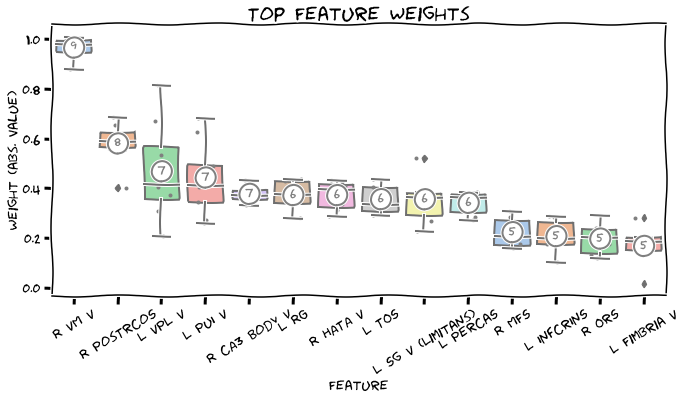

<Figure size 432x288 with 0 Axes>

In [41]:
# boxplot of the dataframe where y=weight and x=feature

fig = plt.figure(figsize=(11, 5))
#sns.set(rc={'figure.figsize':(20, 8)})
with plt.xkcd():
    sns.boxplot(data=top_weights, x="feature", y="weight",orient="v", palette="pastel", order=top_weights.groupby('feature').mean()
                .sort_values('weight', ascending=False).index, showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", 
                                                                                            "markersize":"20", "markeredgecolor":"gray", "markeredgewidth":"2"})
    # store means of boxplot in a list
    means = []
    for i, _ in  enumerate(top_features):
        means.append((top_weights.groupby('feature').mean().sort_values('weight', ascending=False)['weight'][i]))

    plt.xlabel('Feature')
    plt.ylabel('Weight (abs. value)')
    plt.title('Top Feature Weights', size=20)
    plt.xticks(rotation=30)
    sns.stripplot(data=top_weights, x="feature", y="weight", color="gray", zorder=1, size=4, jitter=0.2, order=top_weights.groupby('feature')
                .mean().sort_values('weight', ascending=False).index)

    # add text labels corresponding to top_features_importance at each of the means
    for i,_ in enumerate(top_features):
        plt.text(x=i, y=(means[i]-0.005), s=top_features_importance[i], color='gray', ha="center", fontsize=12)

    plt.savefig('out/feature_weights.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()


In [42]:
# T-TEST
#############################################################

top_features_dataframe = ml_dataframe[top_features]
top_features_dataframe['diagnosis'] = ml_dataframe['diagnosis']

# calculate mean for each column and put in list
means = []
for i, _ in enumerate(top_features):
    means.append(top_features_dataframe.mean()[top_features[i]])

# melt and organize dataframe
top_features_dataframe = top_features_dataframe.melt(id_vars=['diagnosis'], var_name='feature', value_name='value').fillna(0)
top_features_dataframe['feature'] = [feature_names[feature] for feature in top_features_dataframe['feature']]

# set up groups for t-test
ms_dataframe = ml_dataframe[ml_dataframe['diagnosis'] == 'MS']
ms_tn_dataframe = ml_dataframe[ml_dataframe['diagnosis'] == 'MS-TN']

/tmp/ipykernel_30551/1824642321.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features_dataframe['diagnosis'] = ml_dataframe['diagnosis']
/tmp/ipykernel_30551/1824642321.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means.append(top_features_dataframe.mean()[top_features[i]])


In [43]:
# run t-test
# list_of_important_predictors = important_features['feature'].tolist()
# print(list_of_important_predictors)

p_vals = []
p_corrected = []
stats_vals = []

for feature in top_features:
    input_ms = ms_dataframe[feature]
    input_ms_tn = ms_tn_dataframe[feature]
    ttest1 = stats.ttest_ind(input_ms, input_ms_tn, equal_var=True, nan_policy="omit", permutations=None, random_state=None, alternative="two-sided", trim=0)
    #nan_policy='propagate' when all data there
    p_vals.append(ttest1.pvalue)
    stats_vals.append(ttest1.statistic)

In [44]:
# correct p-values for multiple tests

rejected_pval, p_corrected = fdrcorrection(p_vals, alpha=0.05, method='indep')

# replace rejected p-values with "NS"
for i in range(len(p_corrected)):
    if rejected_pval[i] == False:
        p_corrected[i] = 1
    else:
        p_corrected[i] = p_corrected[i]

# save p_corrected to a csv
p_corrected_df = pd.DataFrame(p_corrected, columns=['p_corrected'])
p_corrected_df['feature'] = top_features
p_corrected_df.to_csv('out/p_corrected.csv')

p_corrected_df['p_corrected'] = ['NS' if p_corrected == 1 else '*' if p_corrected > 0.01 
                                 else '**' if p_corrected > 0.001 else '***' for p_corrected in p_corrected_df['p_corrected']]

p_values_codes = p_corrected_df['p_corrected'].tolist()

print(p_values_codes)

['NS', '***', '***', '***', '***', 'NS', '**', '*', '**', 'NS', '**', '***', 'NS', '***']


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

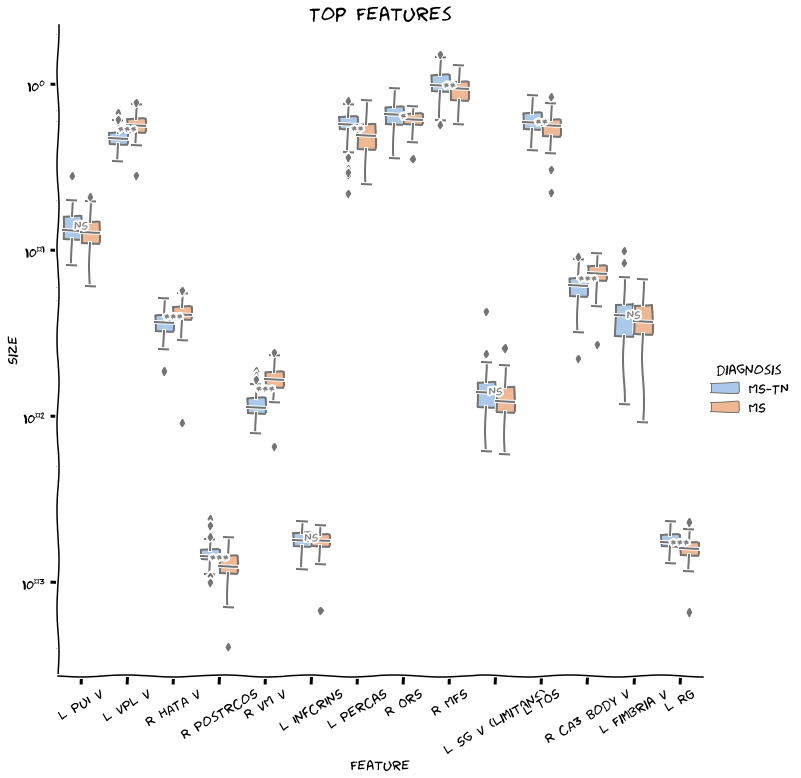

<Figure size 432x288 with 0 Axes>

In [45]:
# plotting the values of the top predictors

with plt.xkcd():
    sns.catplot(data=top_features_dataframe, kind="box", x="feature", y="value", hue="diagnosis", height=10, aspect=1, palette="pastel")        
    plt.xticks(rotation=30)
    # add text labels corresponding to top_features_importance at each of the means
    for i,_ in enumerate(top_features):
        plt.text(x=i, y=(means[i]), s=p_values_codes[i], color='gray', ha="center", fontsize=12)
    plt.yscale('log')
    plt.xlabel('Feature')
    plt.ylabel('Size')
    plt.title('Top Features', size=20)
    plt.savefig('out/top_feature_values.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()